In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruits/Apple_Banana_Orange_Datasets/data.yaml
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/JPEG-image-123_jpeg.rf.2ae17b09f7b7cadadfbc8d13b5428708.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/100314_jpg.rf.ba78c9c842e9614b82111dac003b6fd2.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/bananaNew1_481_jpg.rf.92669934afaf8bcf95bb27b8c8c5909a.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/921_jpg.rf.13b2634ef7f4d46b50b683ebec20f7b7.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/ab-7-_jpg.rf.635e1399202e5cd39d6b2701dc51f2e6.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/AQADbMIxGwbq6Ety_jpg.rf.2d979b3b058c9517aaa312cf89fa7f27.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/bananaNew1_426_jpg.rf.046788c1e806d65bddf759b98068f703.txt
/kaggle/input/fruits/Apple_Banana_Orange_Datasets/val/labels/AQAD_b0xG_SYsEty_jpg.rf.c7dc17e990e81624101992b8d34594ad.txt
/ka

In [2]:
import shutil

src = "/kaggle/input/fruits/Apple_Banana_Orange_Datasets"
dst = "/kaggle/working/dataset"

shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied to:", dst)


Copied to: /kaggle/working/dataset


In [3]:
!ls /kaggle/working


dataset


In [4]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import cv2
import os

In [5]:
os.listdir()

['.virtual_documents', 'dataset']

In [32]:
annotation_dirs = ["/kaggle/working/dataset/train/labels", "/kaggle/working/dataset/val/labels"]
images_dirs = ["/kaggle/working/dataset/train/images", "/kaggle/working/dataset/val/images"]

print(f'Before : {len(os.listdir(annotation_dirs[0]))}')
print(f'Before : {len(os.listdir(annotation_dirs[1]))}')

for annotation_dir, images_dir in zip(annotation_dirs, images_dirs):
    annotations = os.listdir(annotation_dir)
    images = set(os.listdir(images_dir)) 

    for annotation in annotations:
        annotation_file = os.path.join(annotation_dir, annotation)
        image_file_name = annotation[:-4] + '.jpg'

        if image_file_name not in images:
            os.remove(annotation_file)
            continue 

        with open (annotation_file,"r") as f:
            for line in f:
                data = line.strip().split()
                if len(data) < 5:
                    f.close()
                    os.remove(annotation_file)
                break

print(f'After : {len(os.listdir(annotation_dirs[0]))}')
print(f'After : {len(os.listdir(annotation_dirs[1]))}')

Before : 1228
Before : 872
After : 1228
After : 872


In [24]:
class CustomDataset():
    def __init__(self, image_dir, annotations, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_dir, annotation[:-4] + '.jpg')

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        height, width, _ = image.shape

        annotation_file = os.path.join(self.annotations_dir, annotation)
        boxes = []
        labels = []

        with open(annotation_file, "r") as f:
            for line in f:
                data = line.strip().split()
                class_index = int(data[0])  # Class index
                x_center = float(data[1]) * width
                y_center = float(data[2]) * height
                box_width = float(data[3]) * width
                box_height = float(data[4]) * height

                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_index + 1))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}

        return image, target

In [33]:
num_classes = 4 

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

print(model)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes)


for param in model.backbone.parameters():
    param.requires_grad = True

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [34]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [35]:
train_image_dir = "/kaggle/working/dataset/train/images"
train_annotation_dir = "/kaggle/working/dataset/train/labels"
train_annotations = os.listdir(train_annotation_dir)

train_dataset = CustomDataset(train_image_dir, train_annotations, train_annotation_dir, transform=transforms.ToTensor())
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [36]:
print(len(train_data_loader))

307


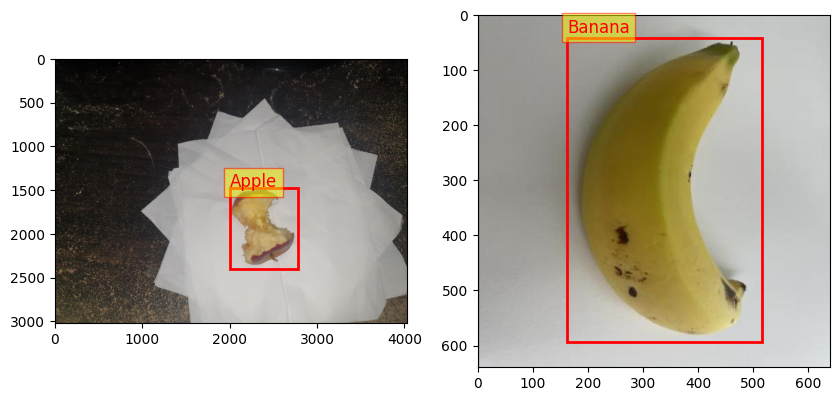

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

data_loader_iter = iter(train_data_loader)
images, targets = next(data_loader_iter)


class_names = ['bg', 'Apple', 'Banana', 'Orange' ]
for idx in range(2):
    image = images[idx].permute(1, 2, 0).numpy()  
    target = targets[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    ax[idx].imshow(image)

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax[idx].add_patch(rect)
        ax[idx].text(
            xmin,
            ymin - 10,
            f"{class_names[label]}",
            color="red",
            fontsize=12,
            bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
        )

plt.show()

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10



In [41]:
train_loss = []
val_loss = []

for epoch in range(num_epochs):

    print(f'Starting the trainig of Epoch_{epoch+1}.....')
    print('Training...')

    model.train()
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs} training')


    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward() 
        optimizer.step() 

        train_running_loss += losses.item()

    scheduler.step()
    train_loss.append(train_running_loss)
    print(f"Train_Loss: {train_running_loss/len(train_dataset):.4f}")
    print('\n')

Starting the trainig of Epoch_1.....
Training...
Epoch 1/10 training
Train_Loss: 0.0559


Starting the trainig of Epoch_2.....
Training...
Epoch 2/10 training
Train_Loss: 0.0271


Starting the trainig of Epoch_3.....
Training...
Epoch 3/10 training
Train_Loss: 0.0225


Starting the trainig of Epoch_4.....
Training...
Epoch 4/10 training
Train_Loss: 0.0195


Starting the trainig of Epoch_5.....
Training...
Epoch 5/10 training
Train_Loss: 0.0191


Starting the trainig of Epoch_6.....
Training...
Epoch 6/10 training
Train_Loss: 0.0189


Starting the trainig of Epoch_7.....
Training...
Epoch 7/10 training
Train_Loss: 0.0185


Starting the trainig of Epoch_8.....
Training...
Epoch 8/10 training
Train_Loss: 0.0186


Starting the trainig of Epoch_9.....
Training...
Epoch 9/10 training
Train_Loss: 0.0186


Starting the trainig of Epoch_10.....
Training...
Epoch 10/10 training
Train_Loss: 0.0185




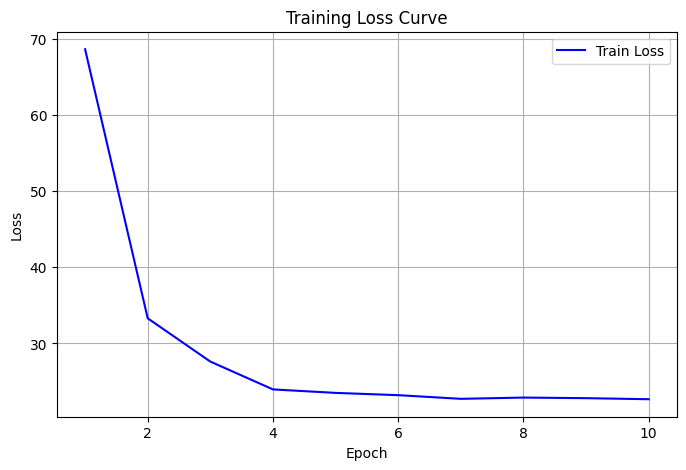

In [43]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
torch.save(model.state_dict(), "faster_rcnn_custom.pth")

{'boxes': tensor([[404.3927,  25.7591, 636.1096, 264.2525],
        [292.7676, 202.4604, 583.5204, 493.1782]], device='cuda:0'), 'labels': tensor([3, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.2990], device='cuda:0')}
{'boxes': tensor([[165.5726, 263.6690, 502.2711, 576.2505],
        [243.2126,  95.7419, 530.5797, 335.0139],
        [614.9673, 155.7296, 639.6691, 361.0488],
        [193.1364, 102.9446, 533.7673, 510.8424],
        [179.1555, 256.7815, 478.1633, 416.8650],
        [237.7760, 105.9689, 417.2502, 281.7947],
        [420.3669, 317.5474, 510.9380, 520.1530]], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'scores': tensor([0.9977, 0.9912, 0.8933, 0.8402, 0.1060, 0.1043, 0.0601],
       device='cuda:0')}
{'boxes': tensor([[ 909.5460, 1254.8000, 2135.5862, 1967.1375]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9556], device='cuda:0')}
{'boxes': tensor([[ 17.2211,  39.3512, 292.6326, 252.5549]], device='c

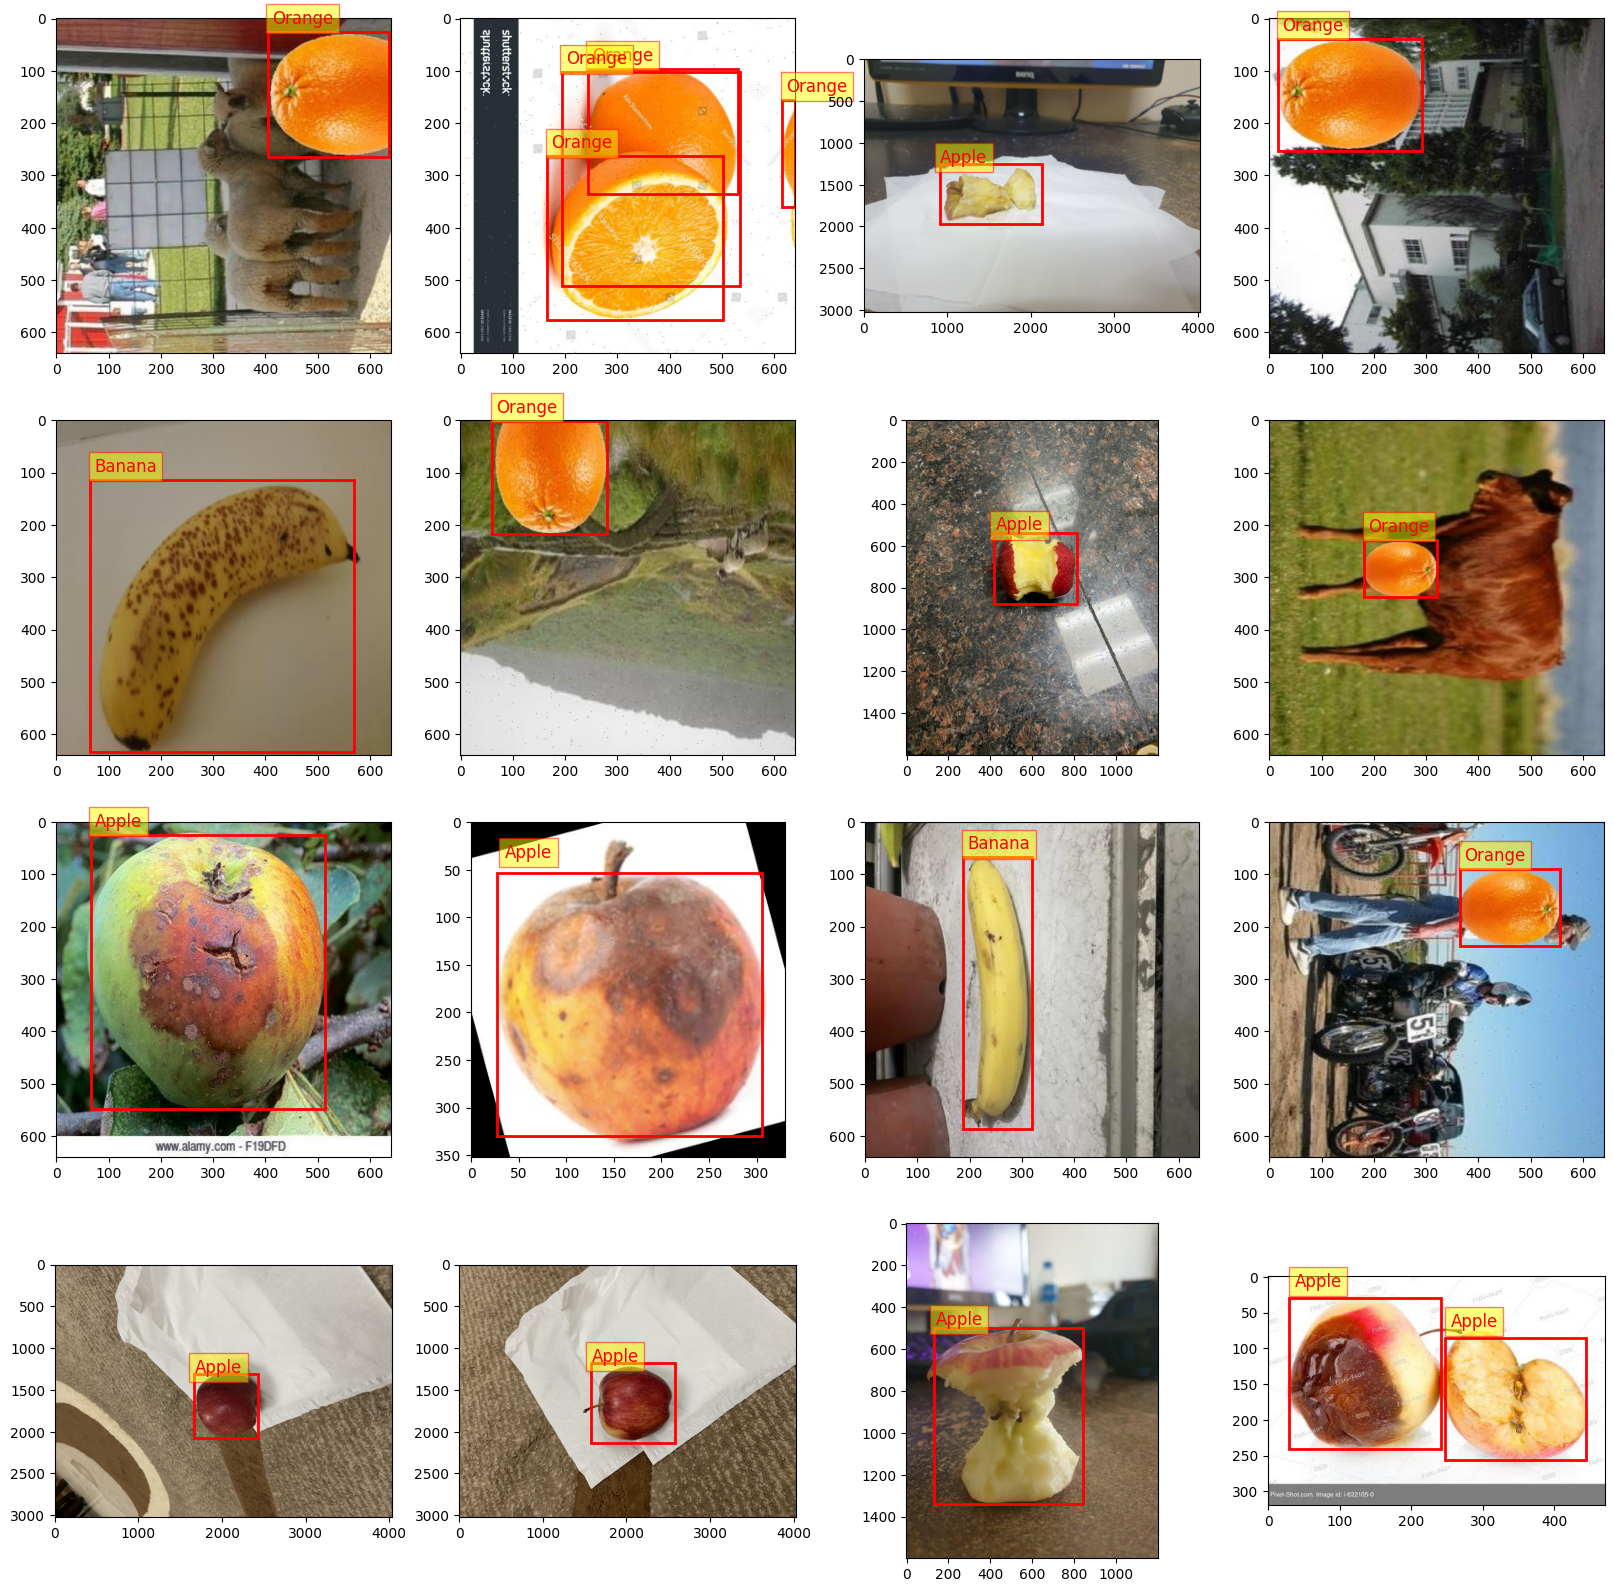

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image,ImageDraw
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.load_state_dict(torch.load("faster_rcnn_custom.pth"))
model.eval()  
model.to(device)  

fig, ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "/kaggle/working/dataset/test/images"
test_list_file = os.listdir(test_dir)


class_names = ['bg', 'Apple', 'Banana', 'Orange']

for idx in range(16):
    img_path = os.path.join(test_dir,random.choice(test_list_file))
    image = Image.open(img_path)
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device)  

    with torch.no_grad():
        prediction = model(image_tensor)[0]  

    print(prediction)

    image_np = image.cpu().permute(1, 2, 0).numpy() 

    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)

    img = Image.open(img_path)
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,0,255),(255,255,0),(0,255,255),(255,140,0),(0,128,0)]

    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"{class_names[label]}",
                color="red",
                fontsize=12,
                bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
            )
            color = random.choice(colors)
            img1 = ImageDraw.Draw(img)
            img1.rectangle([(int(xmin),int(ymin)),(int(xmax),int(ymax))],outline=color,width=4)
            img1.text((int(xmin),int(ymin-30)), "Bear", fill=color)
            # img.save(f'img/image_{idx}.png')

plt.show()

{'boxes': tensor([[227.0075, 242.4173, 467.0204, 570.3146],
        [134.6692, 387.8851, 242.7942, 540.0251]], device='cuda:0'), 'labels': tensor([3, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0577], device='cuda:0')}
{'boxes': tensor([[ 30.0212,  80.8169, 179.2560, 242.6739],
        [  8.5968, 228.2436,  91.4348, 307.9260]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0984], device='cuda:0')}
{'boxes': tensor([[1630.3066,  949.0128, 2725.6409, 1991.3566],
        [  73.0312,  601.2123, 2912.5476, 2859.0693]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9866, 0.0758], device='cuda:0')}
{'boxes': tensor([[1708.4292,  904.5783, 2249.0215, 1682.7308],
        [ 988.1786, 1431.6525, 1093.6072, 1493.6492]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9600, 0.0890], device='cuda:0')}
{'boxes': tensor([[ 64.2828, 139.7505, 238.6607, 300.0262],
        [239.2880, 137.1

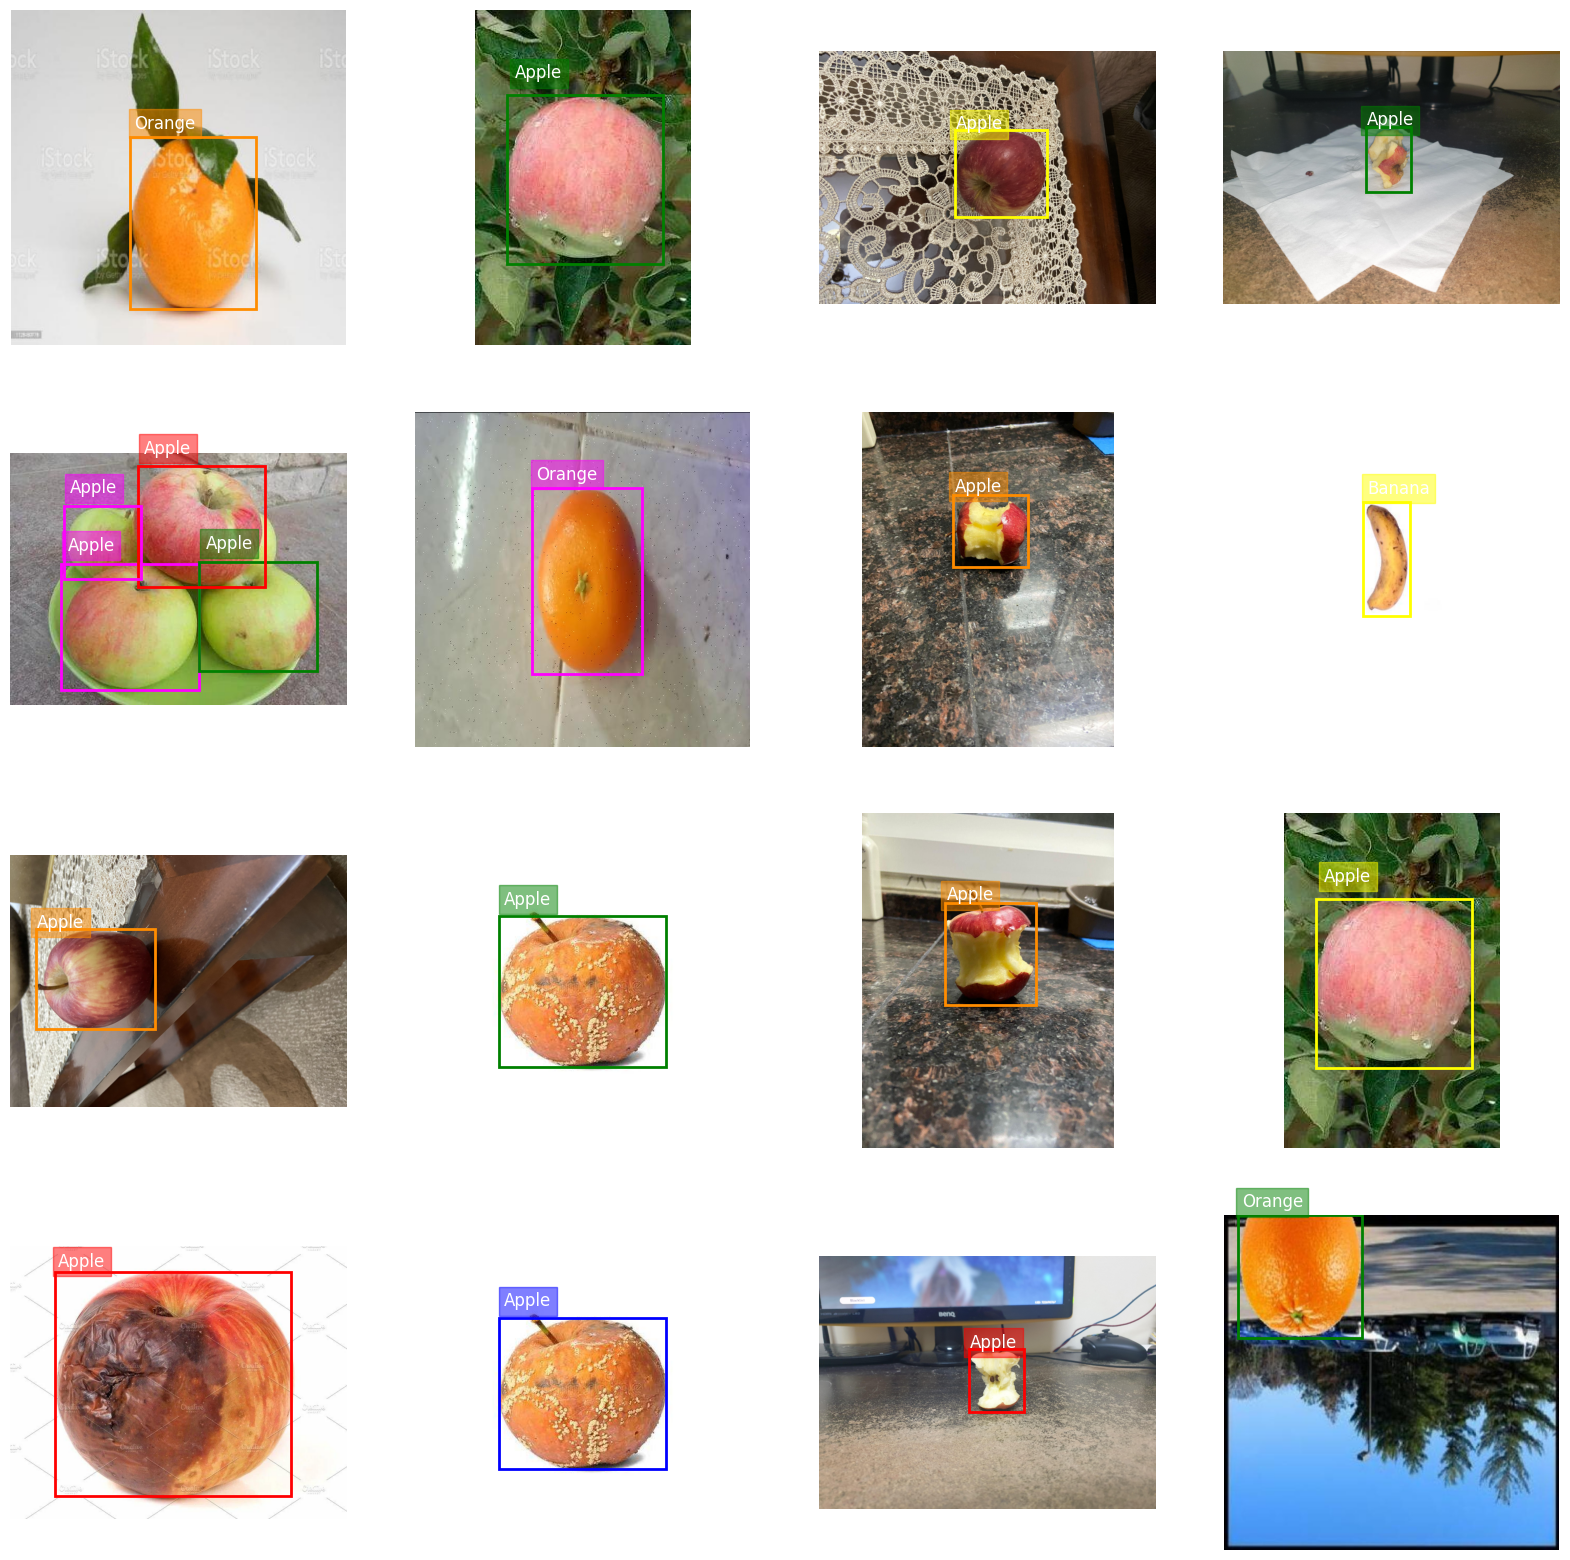

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image,ImageDraw
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.load_state_dict(torch.load("/kaggle/working/faster_rcnn_custom.pth"))
model.eval()
model.to(device) 

fig, ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "/kaggle/working/dataset/test/images"
test_list_file = os.listdir(test_dir)


class_names = ['bg', 'Apple', 'Banana', 'Orange']

for idx in range(16):
    
    img_path = os.path.join(test_dir,random.choice(test_list_file))
    image = Image.open(img_path)
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device) 

    with torch.no_grad():
        prediction = model(image_tensor)[0] 

    print(prediction)

    image_np = image.cpu().permute(1, 2, 0).numpy()  
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)
    ax[idx].axis("off")

    img = Image.open(img_path)
    
    colors = [
        (1, 0, 0),       # Red
        (0, 1, 0),       # Green
        (0, 0, 1),       # Blue
        (1, 0, 1),       # Magenta
        (1, 1, 0),       # Yellow
        (0, 1, 1),       # Cyan
        (1, 0.55, 0),    # Orange
        (0, 0.5, 0)      # Dark Green
    ]

    for box, label, score in zip(boxes, labels, scores):
        color = random.choice(colors)
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"{class_names[label]}",
                color='w',
                fontsize=12,
                bbox=dict(facecolor=color, alpha=0.5, edgecolor=color),
            )
            
    extent = ax[idx].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

plt.show()

In [ ]:
# !zip -r /kaggle/working/faster_rcnn_custom.zip /kaggle/working/faster_rcnn_custom.pth
